# ADA Project : Milestone 2

## TITLE

Description kekw.

### 1) Imports

In [2]:
# installs
#python3 -m pip install nltk

In [3]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import requests
import gzip
import math
from bs4 import BeautifulSoup
import json
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer



### 2) Utility functions

In [4]:
def freebase_to_wiki_id(freebase_id) -> str | None:
    """
    Query Wikidata ID from Freebase ID
    :param freebase_id: str
    :return: corresponding wiki ID
    """
    url = f"https://www.wikidata.org/w/index.php?search={freebase_id}&title=Special%3ASearch&go=Go"
    res = BeautifulSoup(requests.get(url).text, "html.parser")\
        .find("div", {"class": "mw-search-result-heading"})
    if res is not None:
        return res.find("a")["href"].split("/")[-1]
    return None

path_corenlp = '../data/corenlp_plot_summaries/'

def parse_summaries(file: str) -> BeautifulSoup:
    """
    Parse XML npl processed summary
    :param file: name of
    :return: BeautifulSoup object
    """
    with gzip.open(path_corenlp + file, 'rb') as f:
        data = f.read()
    return BeautifulSoup(data, features="xml")

### 3) Movie metadata analysis and processing

In [5]:
# Load the dataset
metadata_df = pd.read_csv('data/movie.metadata.tsv', sep="\t")
metadata_df

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples)
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [6]:
# Get some insights
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Wikipedia movie ID                         81741 non-null  int64  
 1   Freebase movie ID                          81741 non-null  object 
 2   Movie name                                 81741 non-null  object 
 3   Movie release date                         74839 non-null  object 
 4   Movie box office revenue                   8401 non-null   float64
 5   Movie runtime                              61291 non-null  float64
 6   Movie languages                            81741 non-null  object 
 7   Movie countries (Freebase ID:name tuples)  81741 non-null  object 
 8   Movie genres (Freebase ID:name tuples)     81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


Since the revenue is an important feature in our study, let's see if we have enough data

In [7]:
metadata_df['Movie box office revenue'].isna().sum() / metadata_df.shape[0] * 100

89.72241592346558

Around 90% of the movie revenues are absent. We used the boxoffice.csv dataset to enrich our dataset

In [8]:
# Add a release year column for convenience
metadata_df['Movie release year'] = metadata_df['Movie release date'].astype(str).str[:4]
metadata_df = metadata_df[metadata_df["Movie release year"].str.contains("nan") == False]
metadata_df['Movie release year'] = metadata_df['Movie release year'].apply(lambda x: int(x))

/var/folders/_w/3y7kpcx16kg4xgt9lv1j38c00000gn/T/ipykernel_16123/3971724886.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['Movie release year'] = metadata_df['Movie release year'].apply(lambda x: int(x))


In [9]:
# Load the revenue dataset
revenue = pd.read_csv('data/boxoffice.csv', sep=',')

In [10]:
# Fill some of the absent revenue fields from the boxoffice dataset
metadata_df.set_index(['Movie name','Movie release year'])
revenue.set_index(['title','year'])
metadata_df['Movie box office revenue'] = metadata_df['Movie box office revenue'].fillna(revenue['lifetime_gross'])
#metadata_df.reset_index()

/var/folders/_w/3y7kpcx16kg4xgt9lv1j38c00000gn/T/ipykernel_16123/2854674971.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['Movie box office revenue'] = metadata_df['Movie box office revenue'].fillna(revenue['lifetime_gross'])


In [11]:
metadata_df['Movie box office revenue'].isna().sum() / metadata_df.shape[0] * 100

71.77808361950319

We gained around 20% of relevant data! Now load various IMDb datasets:

### 3.1) Additional data on movies' ratings

In [12]:
# IMDb ratings dataset
imdb_ratings_df = pd.read_csv('data/imdb_title_ratings.tsv', sep='	')
imdb_ratings_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1924
1,tt0000002,5.8,260
2,tt0000003,6.5,1733
3,tt0000004,5.6,174
4,tt0000005,6.2,2545


In [13]:
# IMDb videos' metadata dataset
imdb_names_df = pd.read_csv('data/imdb_title_basics.tsv', sep='	', low_memory=False)
# Only keep audiovisual products labeled as movies
imdb_names_df = imdb_names_df[imdb_names_df['titleType'] == 'movie']
imdb_names_df.head(10)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama
625,tt0000630,movie,Hamlet,Amleto,0,1908,\N,\N,Drama
668,tt0000675,movie,Don Quijote,Don Quijote,0,1908,\N,\N,Drama
672,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0,1908,\N,120,"Adventure,Fantasy"
828,tt0000838,movie,A Cultura do Cacau,A Cultura do Cacau,0,1909,\N,\N,\N
832,tt0000842,movie,De Garraf a Barcelona,De Garraf a Barcelona,0,1909,\N,\N,\N


In [14]:
# Join between IMDb movies' rating and metadata
imdb_ratings_meta = imdb_ratings_df.merge(imdb_names_df, on='tconst', how='inner')
imdb_ratings_meta.head(10)

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000009,5.2,200,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
1,tt0000502,4.2,14,movie,Bohemios,Bohemios,0,1905,\N,100,\N
2,tt0000574,6.0,794,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
3,tt0000591,5.1,20,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
4,tt0000615,4.3,23,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama
5,tt0000630,2.9,25,movie,Hamlet,Amleto,0,1908,\N,\N,Drama
6,tt0000675,4.2,19,movie,Don Quijote,Don Quijote,0,1908,\N,\N,Drama
7,tt0000679,5.2,66,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0,1908,\N,120,"Adventure,Fantasy"
8,tt0000862,4.5,16,movie,Faldgruben,Faldgruben,0,1909,\N,\N,\N
9,tt0000886,4.7,38,movie,"Hamlet, Prince of Denmark",Hamlet,0,1910,\N,\N,Drama


In [15]:
# Join between CMU and IMDb datasets
ratings_merge = metadata_df.merge(imdb_ratings_meta, left_on='Movie name', right_on = 'primaryTitle', how='inner')

In [16]:
print(ratings_merge.shape[0])
print(imdb_ratings_meta.shape[0])
print(metadata_df.shape[0])

86943
282557
74839


In [17]:
ratings_merge.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Movie release year,...,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,4.9,55229,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi"
1,28463795,/m/0crgdbh,Brun bitter,1988,700059566.0,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,...,5.7,40,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama"
2,261236,/m/01mrr1,A Woman in Flames,1983,659363944.0,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,...,6.0,589,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama
3,13696889,/m/03cfc81,The Gangsters,1913-05-29,652270625.0,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,...,5.7,31,movie,The Gangsters,Les truands,0,1957,\N,105,"Comedy,Crime"
4,23070193,/m/064mmt5,The Gangsters,1956,NaN,NaN,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/05p553"": ""Comedy film""}",1956,...,5.7,31,movie,The Gangsters,Les truands,0,1957,\N,105,"Comedy,Crime"


In [18]:
# Format movie release date
ratings_merge['Movie release year'] = ratings_merge['Movie release date'].astype(str).str[:4]
ratings_merge = ratings_merge[ratings_merge["Movie release year"].str.contains("nan") == False]
ratings_merge['Movie release year'] = ratings_merge['Movie release year'].apply(lambda x: int(x))

In [19]:
# Filter pairs (obtained by join) by almost same release year (max. difference of two)
ratings_merge = ratings_merge[ratings_merge['startYear'] != '\\N']
ratings_merge['releaseDiff'] = (ratings_merge['Movie release year'].astype(int) - ratings_merge['startYear'].astype(int)).abs()
ratings_merge = ratings_merge[ratings_merge['releaseDiff'] <= 2]

In [20]:
print(ratings_merge.shape[0])

45308


In [21]:
# Filter pairs (obtained by join) by almost same runtime (max. difference of 10% with respect of CMU duration)
ratings_merge = ratings_merge[ratings_merge['runtimeMinutes'] != '\\N']
ratings_merge['Movie runtime'].fillna(-1, inplace=True)

ratings_merge['runtimeDiff'] = (ratings_merge['Movie runtime'].astype(int) - ratings_merge['runtimeMinutes'].astype(int)).abs()
ratings_merge = ratings_merge[ratings_merge['runtimeDiff'] <= ratings_merge['Movie runtime']/10]

In [22]:
print(ratings_merge.shape[0])

34667


In [23]:
ratings_merge.head(10)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Movie release year,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,releaseDiff,runtimeDiff
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi",0,0
1,28463795,/m/0crgdbh,Brun bitter,1988,700059566.0,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,...,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama",0,0
2,261236,/m/01mrr1,A Woman in Flames,1983,659363944.0,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,...,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama,0,0
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,623357910.0,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",2002,...,movie,The Sorcerer's Apprentice,The Sorcerer's Apprentice,0,2001,\N,86,"Adventure,Family,Fantasy",1,0
13,12621957,/m/05pdd86,The Sorcerer's Apprentice,2010-07-08,215283742.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",2010,...,movie,The Sorcerer's Apprentice,The Sorcerer's Apprentice,0,2010,\N,109,"Action,Adventure,Family",0,2
14,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,...,movie,Alexander's Ragtime Band,Alexander's Ragtime Band,0,1938,\N,106,"Drama,Music,Musical",0,0
16,175026,/m/017n1p,Sarah and Son,1930,532177324.0,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",1930,...,movie,Sarah and Son,Sarah and Son,0,1930,\N,86,"Drama,Romance",0,0
17,24229100,/m/07kjkz6,Lady Snowblood 2: Love Song of Vengeance,1974,504014165.0,89.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",1974,...,movie,Lady Snowblood 2: Love Song of Vengeance,Shurayukihime: Urami renka,0,1974,\N,89,"Drama,Thriller",0,0
19,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,...,movie,Henry V,Henry V,0,1989,\N,137,"Biography,Drama,History",0,0
22,80493,/m/0ktqc,Henry V,1944,NaN,135.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/04xvh5"": ""Costume drama"", ""/m/0520lz"": ""R...",1944,...,movie,Henry V,The Chronicle History of King Henry the Fifth ...,0,1944,\N,137,"Biography,Drama,History",0,2


In [24]:
# Clean dataframe

ratings_merge = ratings_merge.drop('releaseDiff', axis=1)
ratings_merge = ratings_merge.drop('runtimeDiff', axis=1)
ratings_merge = ratings_merge.drop('endYear', axis=1)
ratings_merge = ratings_merge.drop('Movie name', axis=1)
ratings_merge = ratings_merge.drop('Movie release date', axis=1)
ratings_merge = ratings_merge.drop('runtimeMinutes', axis=1)
ratings_merge = ratings_merge.drop('titleType', axis=1)

ratings_merge = ratings_merge[['Wikipedia movie ID', 'Freebase movie ID', 'tconst', 'primaryTitle', 'originalTitle', 'Movie box office revenue', 'averageRating', 'numVotes', 'Movie runtime', 'Movie languages', 'Movie countries (Freebase ID:name tuples)', 'Movie genres (Freebase ID:name tuples)', 'genres', 'isAdult', 'startYear']]

In [25]:
ratings_merge.head(10)

,Wikipedia movie ID,Freebase movie ID,tconst,primaryTitle,originalTitle,Movie box office revenue,averageRating,numVotes,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),genres,isAdult,startYear
0,975900,/m/03vyhn,tt0228333,Ghosts of Mars,Ghosts of Mars,14010832.0,4.9,55229,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Action,Horror,Sci-Fi",0,2001
1,28463795,/m/0crgdbh,tt0094806,Brun bitter,Brun bitter,700059566.0,5.7,40,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","Crime,Drama",0,1988
2,261236,/m/01mrr1,tt0083949,A Woman in Flames,Die flambierte Frau,659363944.0,6.0,589,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",Drama,0,1983
6,18998739,/m/04jcqvw,tt0120166,The Sorcerer's Apprentice,The Sorcerer's Apprentice,623357910.0,4.2,605,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Adventure,Family,Fantasy",0,2001
13,12621957,/m/05pdd86,tt0963966,The Sorcerer's Apprentice,The Sorcerer's Apprentice,215283742.0,6.1,162916,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...","Action,Adventure,Family",0,2010
14,10408933,/m/02qc0j7,tt0029852,Alexander's Ragtime Band,Alexander's Ragtime Band,3600000.0,6.9,2159,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...","Drama,Music,Musical",0,1938
16,175026,/m/017n1p,tt0021335,Sarah and Son,Sarah and Son,532177324.0,5.4,272,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...","Drama,Romance",0,1930
17,24229100,/m/07kjkz6,tt0072157,Lady Snowblood 2: Love Song of Vengeance,Shurayukihime: Urami renka,504014165.0,6.3,3809,89.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...","Drama,Thriller",0,1974
19,171005,/m/016ywb,tt0097499,Henry V,Henry V,10161099.0,7.5,30161,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...","Biography,Drama,History",0,1989
22,80493,/m/0ktqc,tt0036910,Henry V,The Chronicle History of King Henry the Fifth ...,NaN,7.0,6561,135.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/04xvh5"": ""Costume drama"", ""/m/0520lz"": ""R...","Biography,Drama,History",0,1944


In [26]:
metadata_df = ratings_merge
box_office_rev = 'Movie box office revenue'
box_office_rat = 'averageRating'

metadata_df = metadata_df[metadata_df[box_office_rev].notnull() & metadata_df[box_office_rat].notnull()]

In [27]:
metadata_df

,Wikipedia movie ID,Freebase movie ID,tconst,primaryTitle,originalTitle,Movie box office revenue,averageRating,numVotes,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),genres,isAdult,startYear
0,975900,/m/03vyhn,tt0228333,Ghosts of Mars,Ghosts of Mars,14010832.0,4.9,55229,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Action,Horror,Sci-Fi",0,2001
1,28463795,/m/0crgdbh,tt0094806,Brun bitter,Brun bitter,700059566.0,5.7,40,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","Crime,Drama",0,1988
2,261236,/m/01mrr1,tt0083949,A Woman in Flames,Die flambierte Frau,659363944.0,6.0,589,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",Drama,0,1983
6,18998739,/m/04jcqvw,tt0120166,The Sorcerer's Apprentice,The Sorcerer's Apprentice,623357910.0,4.2,605,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Adventure,Family,Fantasy",0,2001
13,12621957,/m/05pdd86,tt0963966,The Sorcerer's Apprentice,The Sorcerer's Apprentice,215283742.0,6.1,162916,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...","Action,Adventure,Family",0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86925,1191380,/m/04f_y7,tt0120514,Wilde,Wilde,2158775.0,6.9,17316,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...","Biography,Drama,Romance",0,1997
86926,54540,/m/0f7hw,tt0094898,Coming to America,Coming to America,288752301.0,7.1,208493,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...","Comedy,Romance",0,1988
86931,7761830,/m/0kvgqb,tt0100666,Spaced Invaders,Spaced Invaders,15369573.0,5.3,3738,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie...","Adventure,Comedy,Sci-Fi",0,1990
86936,1918494,/m/0660qx,tt0120202,State and Main,State and Main,6944471.0,6.7,21482,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana...","Comedy,Drama",0,2000


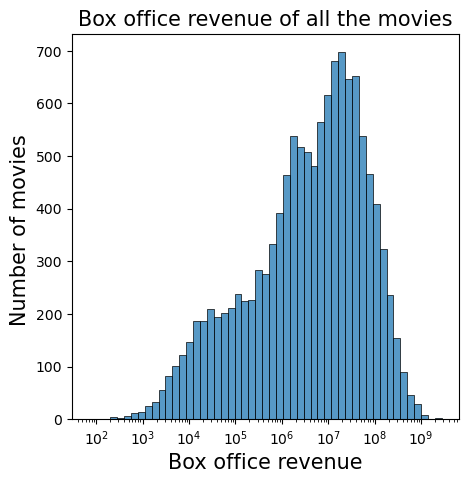

In [28]:
plt.figure(figsize=(5, 5))
plt.xlabel('Box office revenue', fontsize = 15)
plt.ylabel('Number of movies ', fontsize=15)
plt.title('Box office revenue of all the movies', fontsize=15)
sns.histplot(data=metadata_df[box_office_rev], log_scale=True)
plt.show()

In [29]:
profits_year = metadata_df.groupby('startYear')[box_office_rev]
means_year = profits_year.mean()[1:]
sums_year = profits_year.sum()[1:]
means_year

startYear
1914    4.088470e+06
1915    1.905622e+07
1916    8.465867e+07
1917    6.127824e+06
1918    7.908246e+06
            ...     
2009    5.505610e+07
2010    5.701279e+07
2011    5.515565e+07
2012    9.824785e+07
2013    3.001460e+07
Name: Movie box office revenue, Length: 100, dtype: float64

In [30]:
def plot_by_year(df_year: pd.Series, prefix: str):
    """
    Plot a year grouped column
    :param df_year: said column
    :param prefix: str
    """
    fig, ax = plt.subplots()

    fig.set_size_inches(12, 6)
    ax.set_xlabel('Release year', fontsize = 12, )
    ax.set_ylabel(f'{prefix} box office revenue', fontsize = 12)
    ax.set_title(f'{prefix} box office revenue by year')
    ax.set_label("Floats")
    ax.plot(np.asarray(df_year.index, float), df_year.values)

    plt.show()

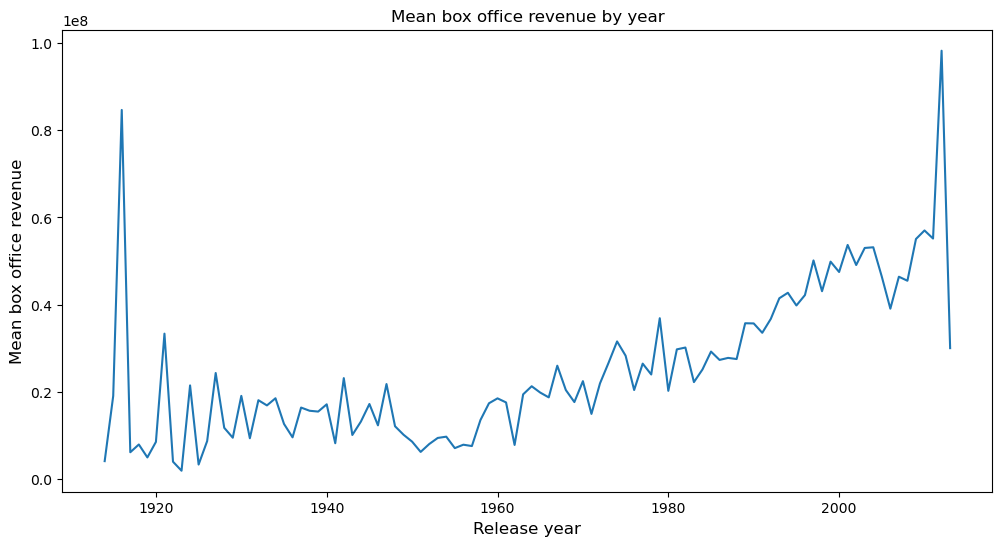

In [31]:
plot_by_year(means_year, "Mean")

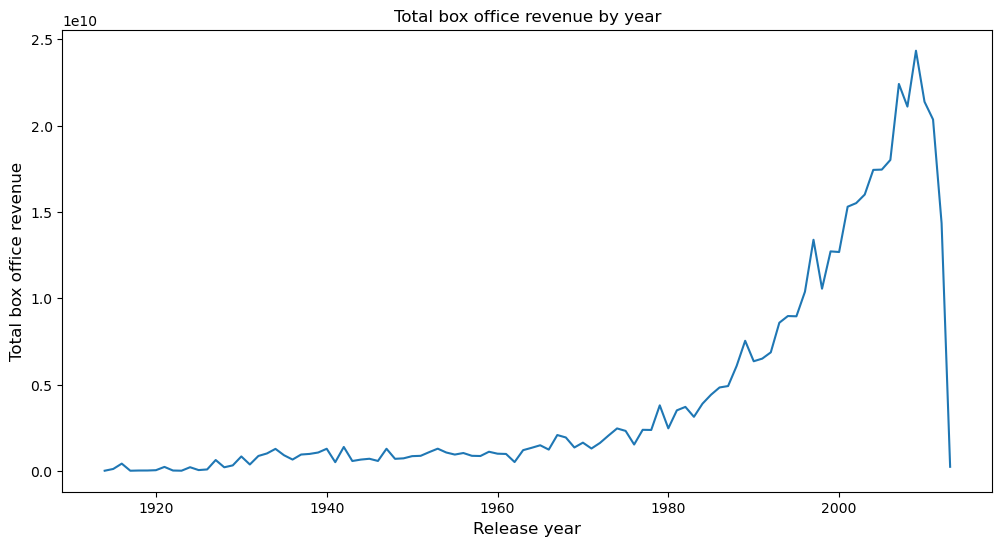

In [32]:
plot_by_year(sums_year, "Total")

In [33]:
metadata_df["Movie runtime"].describe()

count    12435.000000
mean       101.972280
std         21.335271
min         43.000000
25%         90.000000
50%         99.000000
75%        111.000000
max        330.000000
Name: Movie runtime, dtype: float64

In [34]:
def remove_first_and_last_chars(input_str: str) -> str:
    """
    Remove the first and last char of a string.
    :param input_str
    :return: processed string
    """
    if len(input_str) < 2:
        return ""
    return input_str[1:-1]

def separate_id_from_data(paired_string: str, remove_brackets=True) -> (str, str):
    """
    Separates "{"FreebaseID": "some string"}" strings into ("FreebaseID", "some string") tuples.
    :param paired_string: input paired string
    :param remove_brackets: if True, remove the leading and trailing curly brackets
    :return: said tuple of strings
    """
    if remove_brackets:
        paired_string = remove_first_and_last_chars(paired_string)

    ls = paired_string.split(":")
    for i, s in enumerate(ls):
        ls[i] = remove_first_and_last_chars(s.strip())

    if len(ls) < 2:
        return None, None
    return ls[0], ls[1]

def separate_ids_from_list_data(list_paired_string: str) -> (list, list):
    """
    Separates "{"FreebaseID1": "some string 1", "FreebaseID2": "some string 2", etc.}" strings
    into two lists: (["FreebaseID1", "FreebaseID2", ...], ["some string 1", "some string 2", ...]).
    :param list_paired_string: input list of pairs as string
    :return: said tuple of lists
    """
    list_paired_string = remove_first_and_last_chars(list_paired_string)
    split_pairs = list_paired_string.split(",")
    tupled_pairs = [separate_id_from_data(pair, remove_brackets=False) for pair in split_pairs]
    return [p[0] for p in tupled_pairs], [p[1] for p in tupled_pairs]

def col_to_col_values(column_name: str) -> str:
    """
    String formatting for value column names
    :param column_name: original column name
    :return: said formatted string
    """
    return f"{column_name}: values"

def append_processed_columns(df: pd.DataFrame, column_name: str):
    """
    Separate Freebase IDs from values
    :param df: data, modified in place
    :param column_name: name of column where to separate {Freebase ID: value} pairs
    """
    vals = df[column_name].apply(separate_ids_from_list_data).values
    df[f"{column_name}: Freebase IDs"] = [vals[i][0] for i in range(len(vals))]
    df[col_to_col_values(column_name)] = [vals[i][1] for i in range(len(vals))]
    df.drop(column_name, axis=1, inplace=True)

In [35]:
metadata_df.rename(columns={"Movie countries (Freebase ID:name tuples)": "Movie countries",
                    "Movie genres (Freebase ID:name tuples)": "Movie genres"}, inplace=True)

cols_to_process = ["Movie countries", "Movie genres", "Movie languages"]
for col in cols_to_process:
    append_processed_columns(metadata_df, col)

metadata_df

/var/folders/_w/3y7kpcx16kg4xgt9lv1j38c00000gn/T/ipykernel_16123/4012411840.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df.rename(columns={"Movie countries (Freebase ID:name tuples)": "Movie countries",
/var/folders/_w/3y7kpcx16kg4xgt9lv1j38c00000gn/T/ipykernel_16123/179526972.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{column_name}: Freebase IDs"] = [vals[i][0] for i in range(len(vals))]
/var/folders/_w/3y7kpcx16kg4xgt9lv1j38c00000gn/T/ipykernel_16123/179526972.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy 

,Wikipedia movie ID,Freebase movie ID,tconst,primaryTitle,originalTitle,Movie box office revenue,averageRating,numVotes,Movie runtime,genres,isAdult,startYear,Movie countries: Freebase IDs,Movie countries: values,Movie genres: Freebase IDs,Movie genres: values,Movie languages: Freebase IDs,Movie languages: values
0,975900,/m/03vyhn,tt0228333,Ghosts of Mars,Ghosts of Mars,14010832.0,4.9,55229,98.0,"Action,Horror,Sci-Fi",0,2001,[/m/09c7w0],[United States of America],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...","[Thriller, Science Fiction, Horror, Adventure,...",[/m/02h40lc],[English Language]
1,28463795,/m/0crgdbh,tt0094806,Brun bitter,Brun bitter,700059566.0,5.7,40,83.0,"Crime,Drama",0,1988,[/m/05b4w],[Norway],"[/m/0lsxr, /m/07s9rl0]","[Crime Fiction, Drama]",[/m/05f_3],[Norwegian Language]
2,261236,/m/01mrr1,tt0083949,A Woman in Flames,Die flambierte Frau,659363944.0,6.0,589,106.0,Drama,0,1983,[/m/0345h],[Germany],[/m/07s9rl0],[Drama],[/m/04306rv],[German Language]
6,18998739,/m/04jcqvw,tt0120166,The Sorcerer's Apprentice,The Sorcerer's Apprentice,623357910.0,4.2,605,86.0,"Adventure,Family,Fantasy",0,2001,[/m/0hzlz],[South Africa],"[/m/0hqxf, /m/01hmnh, /m/03k9fj, /m/03q4nz]","[Family Film, Fantasy, Adventure, World cinema]",[/m/02h40lc],[English Language]
13,12621957,/m/05pdd86,tt0963966,The Sorcerer's Apprentice,The Sorcerer's Apprentice,215283742.0,6.1,162916,111.0,"Action,Adventure,Family",0,2010,[/m/09c7w0],[United States of America],"[/m/06n90, /m/03k9fj, /m/01hmnh, /m/01z4y, /m/...","[Science Fiction, Adventure, Fantasy, Comedy, ...",[/m/02h40lc],[English Language]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86925,1191380,/m/04f_y7,tt0120514,Wilde,Wilde,2158775.0,6.9,17316,118.0,"Biography,Drama,Romance",0,1997,"[/m/014tss, /m/03_3d, /m/02jx1, /m/07ssc, /m/0...","[Kingdom of Great Britain, Japan, England, Uni...","[/m/0hn10, /m/017fp, /m/0gw5n2f, /m/03g3w, /m/...","[LGBT, Biography, Japanese Movies, History, Ga...",[/m/02h40lc],[English Language]
86926,54540,/m/0f7hw,tt0094898,Coming to America,Coming to America,288752301.0,7.1,208493,117.0,"Comedy,Romance",0,1988,[/m/09c7w0],[United States of America],"[/m/06cvj, /m/03p5xs, /m/07s9rl0, /m/01z4y, /m...","[Romantic comedy, Comedy of manners, Drama, Co...",[/m/02h40lc],[English Language]
86931,7761830,/m/0kvgqb,tt0100666,Spaced Invaders,Spaced Invaders,15369573.0,5.3,3738,100.0,"Adventure,Comedy,Sci-Fi",0,1990,[/m/09c7w0],[United States of America],"[/m/0hj3mt0, /m/06n90, /m/0hqxf, /m/01z4y, /m/...","[Alien Film, Science Fiction, Family Film, Com...",[/m/02h40lc],[English Language]
86936,1918494,/m/0660qx,tt0120202,State and Main,State and Main,6944471.0,6.7,21482,106.0,"Comedy,Drama",0,2000,"[/m/0f8l9c, /m/09c7w0]","[France, United States of America]","[/m/0gf28, /m/09n5t_, /m/01z4y]","[Parody, Americana, Comedy]","[/m/02bjrlw, /m/02h40lc]","[Italian Language, English Language]"


In [36]:
def distinct_values(column_name: str) -> set:
    """
    Get all values from a column
    :param column_name: said column
    :return: set of values
    """
    return set.union(*metadata_df[col_to_col_values(column_name)].apply(set).values)

def name_appended_column(prefix: str, val: str) -> str:
    """
    Format column name
    :param prefix: str
    :param val: str
    :return: str
    """
    return f"{prefix}: {val}"

def append_indicator_columns(df: pd.DataFrame, all_values: set, column_name: str, prefix: str) -> pd.DataFrame:
    """
    Add columns to the right of a dataframe indicating whether a particular value is present or not
    in some initial column listing values of the same family
    :param df: data (not modified)
    :param all_values: all possible values
    :param column_name: column to inspect
    :param prefix: str
    :return: Dataframe with added columns
    """
    cols = [df[col_to_col_values(column_name)]
            .apply(lambda x: 1 if val in x else 0)
            .rename(name_appended_column(prefix, val))
            for val in all_values]
    cols.insert(0, df)
    return pd.concat(cols, axis=1)

In [37]:
all_countries = distinct_values("Movie countries")
all_genres = distinct_values("Movie genres")
all_languages = distinct_values("Movie languages")

genre_prefix = "genre"
langs_prefix = "lang"
cntry_prefix = "country"

In [38]:
for ls in [(all_countries, "Movie countries", cntry_prefix),
            (all_genres, "Movie genres", genre_prefix),
            (all_languages, "Movie languages", langs_prefix)]:
    metadata_df = append_indicator_columns(metadata_df, *ls)

metadata_df

,Wikipedia movie ID,Freebase movie ID,tconst,primaryTitle,originalTitle,Movie box office revenue,averageRating,numVotes,Movie runtime,genres,...,lang: Telugu language,lang: Pashto language,lang: Dutch Language,lang: Punjabi language,lang: Navajo Language,lang: Shanghainese,lang: Hindi Language,lang: Turkish Language,lang: Kuna language,lang: Sioux language
0,975900,/m/03vyhn,tt0228333,Ghosts of Mars,Ghosts of Mars,14010832.0,4.9,55229,98.0,"Action,Horror,Sci-Fi",...,0,0,0,0,0,0,0,0,0,0
1,28463795,/m/0crgdbh,tt0094806,Brun bitter,Brun bitter,700059566.0,5.7,40,83.0,"Crime,Drama",...,0,0,0,0,0,0,0,0,0,0
2,261236,/m/01mrr1,tt0083949,A Woman in Flames,Die flambierte Frau,659363944.0,6.0,589,106.0,Drama,...,0,0,0,0,0,0,0,0,0,0
6,18998739,/m/04jcqvw,tt0120166,The Sorcerer's Apprentice,The Sorcerer's Apprentice,623357910.0,4.2,605,86.0,"Adventure,Family,Fantasy",...,0,0,0,0,0,0,0,0,0,0
13,12621957,/m/05pdd86,tt0963966,The Sorcerer's Apprentice,The Sorcerer's Apprentice,215283742.0,6.1,162916,111.0,"Action,Adventure,Family",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86925,1191380,/m/04f_y7,tt0120514,Wilde,Wilde,2158775.0,6.9,17316,118.0,"Biography,Drama,Romance",...,0,0,0,0,0,0,0,0,0,0
86926,54540,/m/0f7hw,tt0094898,Coming to America,Coming to America,288752301.0,7.1,208493,117.0,"Comedy,Romance",...,0,0,0,0,0,0,0,0,0,0
86931,7761830,/m/0kvgqb,tt0100666,Spaced Invaders,Spaced Invaders,15369573.0,5.3,3738,100.0,"Adventure,Comedy,Sci-Fi",...,0,0,0,0,0,0,0,0,0,0
86936,1918494,/m/0660qx,tt0120202,State and Main,State and Main,6944471.0,6.7,21482,106.0,"Comedy,Drama",...,0,0,0,0,0,0,0,0,0,0


In [39]:
from functools import cmp_to_key

def retrieve_n_most_frequent(df: pd.DataFrame, n: int, all_vals: list, prefix: str) -> list:
    """
    Retrieve the n most frequent genres, languages or countries, sorted in descending order
    of frequency
    :param df: data
    :param n: integer, max number of values to retrieve
    :param all_vals: all possible values
    :param prefix: str
    :return: said list
    """
    def comparator(val1, val2):
        mean_val1 = df[name_appended_column(prefix, val1)].mean()
        mean_val2 = df[name_appended_column(prefix, val2)].mean()
        return mean_val1 - mean_val2
    return sorted(all_vals, key=cmp_to_key(comparator), reverse=True)[:n]

def retrieve_frequent(df: pd.DataFrame, all_vals: list, prefix: str, freq_threshold=0.05) -> list:
    """
    Filter the values with a sufficiently high frequency
    :param df: data
    :param all_vals: all possible values
    :param prefix: str
    :param freq_threshold: float
    :return: list of sufficiently frequent values
    """
    return list(
        filter(
            lambda val: df[name_appended_column(prefix, val)].mean() > freq_threshold,
            all_vals
        )
    )

def map_to_col_names(data_names: list, prefix: str) -> list:
    """
    Convert data values into column names
    :param data_names: list of  data values
    :param prefix: str
    :return: list of formatted column names
    """
    f = lambda x: name_appended_column(prefix, x)
    return list(map(f, data_names))

In [40]:
most_freq_genres = retrieve_n_most_frequent(metadata_df, 35, all_genres, genre_prefix)
suff_freq_genres = retrieve_frequent(metadata_df, all_genres, genre_prefix, freq_threshold=0.03)

most_freq_langs = retrieve_n_most_frequent(metadata_df, 35, all_languages, langs_prefix)
suff_freq_langs = retrieve_frequent(metadata_df, all_languages, langs_prefix, freq_threshold=0.03)

most_freq_cntry = retrieve_n_most_frequent(metadata_df, 35, all_countries, cntry_prefix)
suff_freq_cntry = retrieve_frequent(metadata_df, all_countries, cntry_prefix, freq_threshold=0.03)

In [41]:
def find_correlated_metadata(df: pd.DataFrame, freq_data: list, success_metric: str, prefix: str, sig_level=0.05) -> list:
    """
    Among a list of sufficiently frequent data taken from the metadata dataframe,
    find the values such that they are correlated to a movie's success metric with
    a p-value less than sig-level.
    :param df: input dataframe
    :param freq_data: column names to search in
    :param success_metric: str, name of column in df
    :param prefix: str
    :param sig_level: defaults to 5%
    :return: described list
    """
    correlated_data = []

    for value in freq_data:
        res = stats.spearmanr(df[success_metric], df[name_appended_column(prefix, value)])
        if res.pvalue < sig_level:
            correlated_data.append(value)
    return correlated_data

In [42]:
correlated_genres_to_revenue = find_correlated_metadata(metadata_df, most_freq_genres, box_office_rev, genre_prefix)
correlated_langs_to_revenue = find_correlated_metadata(metadata_df, most_freq_langs, box_office_rev, langs_prefix)
correlated_cntry_to_revenue = find_correlated_metadata(metadata_df, most_freq_cntry, box_office_rev, cntry_prefix)

In [203]:
def plot_metadata_frequency_against_metric(df: pd.DataFrame, prefix: str,  titled_data: list, success_metric: str, log_scale=True):
    """
    Generating a grid of histograms
    :param df: data
    :param prefix: str
    :param titled_data: titles of data, to be converted to column names
    :param success_metric: measured column name
    :param log_scale: determines the scale of the axes
    """

    # Making the data fit into a square grid...
    squares = np.arange(8) ** 2
    shifted_squares = squares - len(titled_data)
    smallest_big_enough_square = squares[np.argmax(shifted_squares > 0) - 1]

    tested_data = map_to_col_names(titled_data, prefix)[:smallest_big_enough_square]
    size = int(np.sqrt(smallest_big_enough_square))

    fig, ax = plt.subplots(size, size, figsize=(11, 11), sharex = True)
    for i in range(smallest_big_enough_square):
        sbplt = ax[i%size, math.floor(i/size)]
        sns.histplot(ax=sbplt, data=df[df[tested_data[i]] == 1][success_metric], log_scale=log_scale)
        sbplt.set_title(titled_data[i])

    fig.tight_layout()

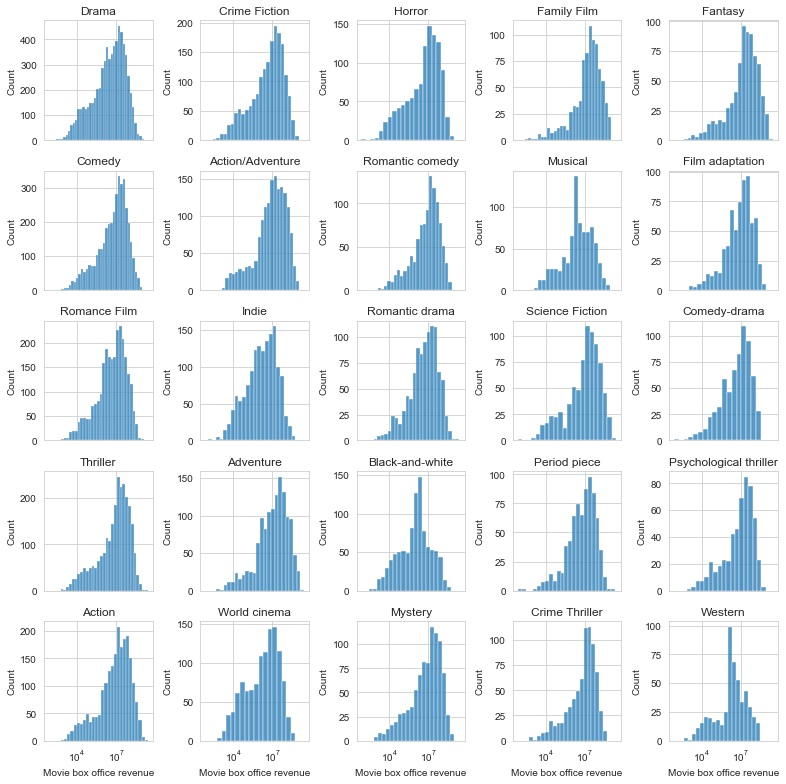

In [204]:
plot_metadata_frequency_against_metric(metadata_df, genre_prefix, correlated_genres_to_revenue, box_office_rev)

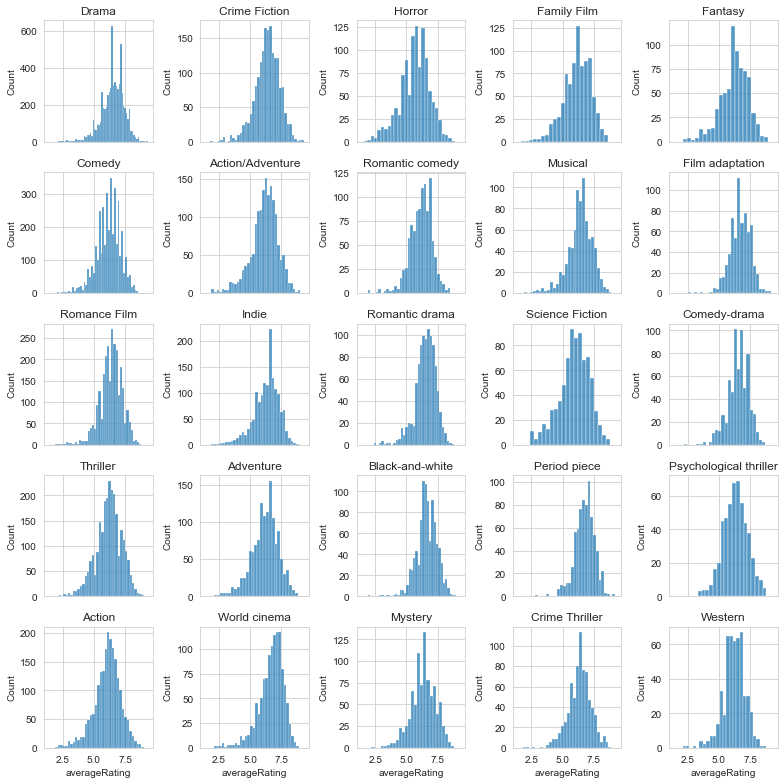

In [205]:
plot_metadata_frequency_against_metric(metadata_df, genre_prefix, correlated_genres_to_revenue, box_office_rat, log_scale=False)

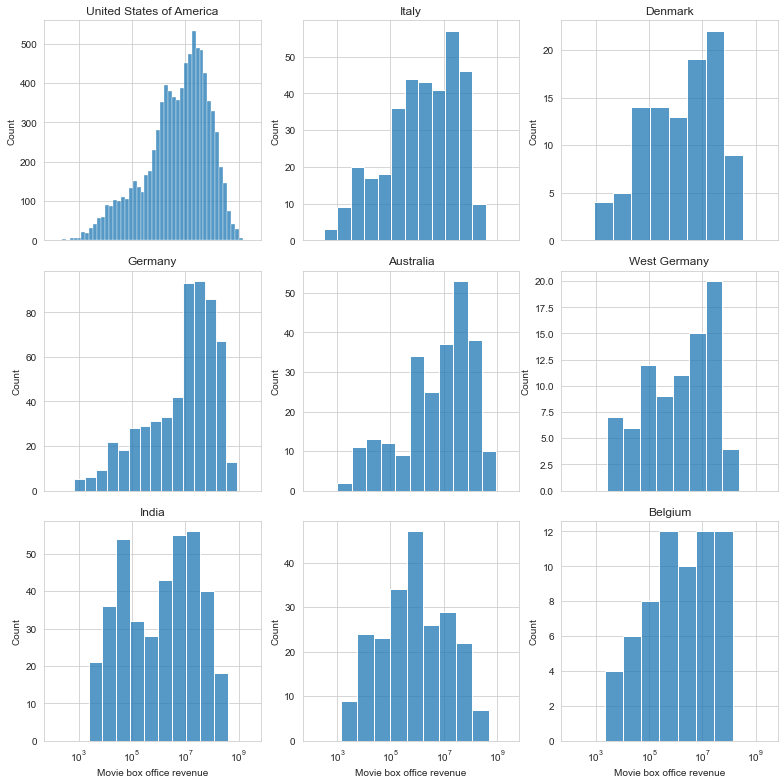

In [206]:
plot_metadata_frequency_against_metric(metadata_df, cntry_prefix, correlated_cntry_to_revenue, box_office_rev)

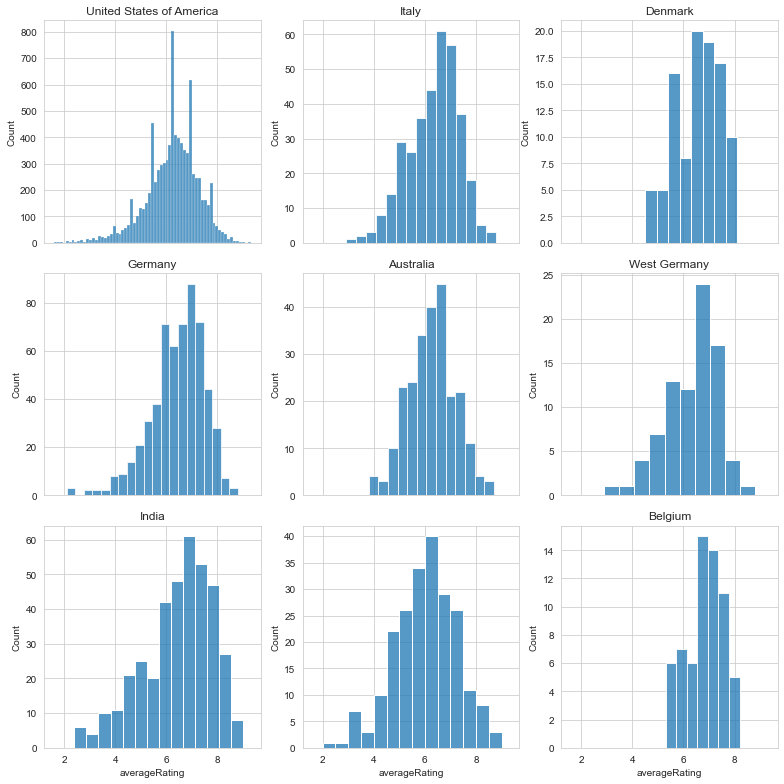

In [207]:
plot_metadata_frequency_against_metric(metadata_df, cntry_prefix, correlated_cntry_to_revenue, box_office_rat, log_scale=False)

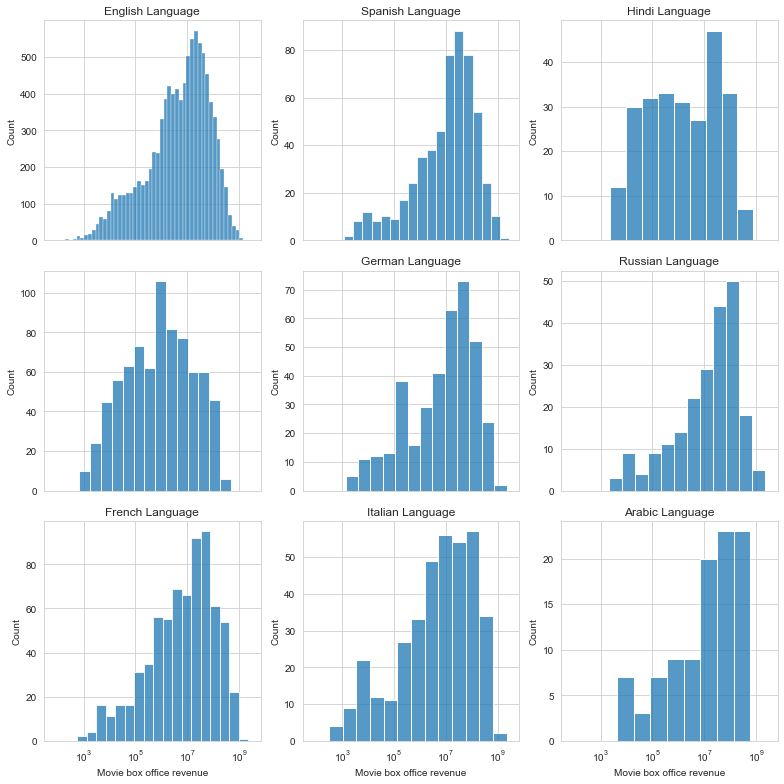

In [208]:
plot_metadata_frequency_against_metric(metadata_df, langs_prefix, correlated_langs_to_revenue, box_office_rev)

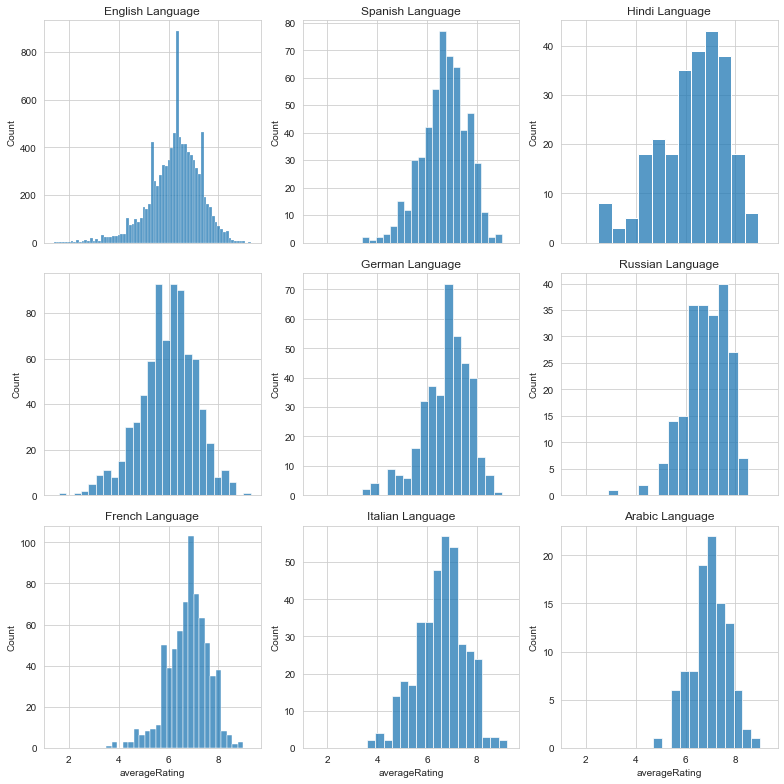

In [209]:
plot_metadata_frequency_against_metric(metadata_df, langs_prefix, correlated_langs_to_revenue, box_office_rat, log_scale=False)

### 4) Character Metadata analysis

In [210]:
# Load the dataset
names_char = ['Wikipedia movie ID',
              'Freebase movie ID',
              'Movie release date',
              'Character name',
              'Actor date of birth',
              'Actor gender',
              'Actor height',
              'Actor ethnicity',
              'Actor name',
              'Actor age at movie release',
              'Freebase character/actor map ID',
              'Freebase character ID',
              'Freebase actor ID']

characters_metadata_df = pd.read_csv('data/character.metadata.tsv', sep='\t', names = names_char)

In [211]:
characters_metadata_df.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [212]:
characters_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Wikipedia movie ID               450669 non-null  int64  
 1   Freebase movie ID                450669 non-null  object 
 2   Movie release date               440674 non-null  object 
 3   Character name                   192794 non-null  object 
 4   Actor date of birth              344524 non-null  object 
 5   Actor gender                     405060 non-null  object 
 6   Actor height                     154824 non-null  float64
 7   Actor ethnicity                  106058 non-null  object 
 8   Actor name                       449441 non-null  object 
 9   Actor age at movie release       292556 non-null  float64
 10  Freebase character/actor map ID  450669 non-null  object 
 11  Freebase character ID            192804 non-null  object 
 12  Fr

<AxesSubplot:xlabel='Actor gender', ylabel='Count'>

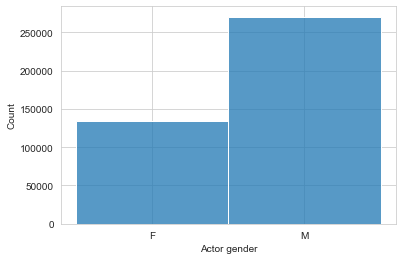

In [213]:
sns.histplot(data=characters_metadata_df, x="Actor gender")

In [214]:
characters_metadata_df[characters_metadata_df['Actor age at movie release'] < 0]

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
767,15007384,/m/03h4h5p,1934-05-02,NaN,1963-11-07,NaN,NaN,NaN,Franck Dubosc,-29.0,/m/0bwb9k3,NaN,/m/01wlly9
2286,2553539,/m/07mlsy,1918-04-14,NaN,1931-03-25,M,NaN,NaN,Tom Wilson,-12.0,/m/0jsqm1,NaN,/m/0382zh
3892,5917218,/m/0fdf3y,1965,NaN,1983-03-03,F,1.75,NaN,Kim Smith,-18.0,/m/04mb5kf,NaN,/m/03pjkv
6666,73930,/m/0jsjm,1924,Robert,1972-11-07,M,1.80,NaN,Jason London,-48.0,/m/01xrptw,/m/02nwfsk,/m/04kdmg
7188,21242801,/m/05bzjwj,1955-08-07,NaN,1973-08-01,M,1.79,/m/03ttfc,Eduardo Noriega,-17.0,/m/0cg2f0f,NaN,/m/0bkkw0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
446570,3642891,/m/09rsyj,1999-10-03,Tess,2936-12-24,F,NaN,NaN,J.J. McColl,-937.0,/m/0l2rdfz,/m/0l2rdg1,/m/0l2rdg8
446581,25868401,/m/09v6ykm,1955,NaN,1967-05-31,F,1.67,/m/03ts0c,Sandrine Bonnaire,-12.0,/m/04j05tr,NaN,/m/07wn_5
446583,8595532,/m/02799cv,1944-02-23,NaN,1947-05-28,M,NaN,NaN,Kevin O'Shea,-3.0,/m/02vcqnq,NaN,/m/02q384f
446816,1276915,/m/04pg6m,1941-06-20,NaN,1957-04-19,M,NaN,NaN,Tony Martin,-15.0,/m/0cg164j,NaN,/m/07q_fg


In [215]:
characters_metadata_df['Actor age at movie release'] = characters_metadata_df['Actor age at movie release'].apply(abs)

(0.0, 100.0)

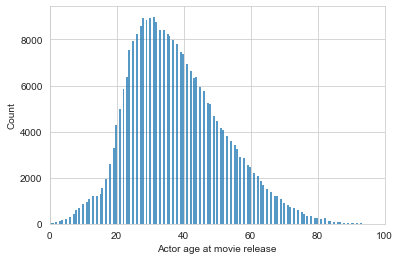

In [216]:
sns.histplot(data=characters_metadata_df, x="Actor age at movie release")
plt.xlim(0, 100)

### 5) tvtropes clusters analysis


In [217]:
with open('data/tvtropes.clusters.txt') as f:
    d = []
    for row in f.readlines():
        t, json_data = row.split('\t')
        data = json.loads(json_data)
        data['type'] = t
        d.append(data)

tv_tropes_df = pd.DataFrame(d)
tv_tropes_df.set_index("id", inplace=True)

In [218]:
tv_tropes_df.head()

,char,movie,actor,type
id,,,,
/m/0jy9q0,Professor Philip Brainard,Flubber,Robin Williams,absent_minded_professor
/m/02vchl3,Professor Keenbean,Richie Rich,Michael McShane,absent_minded_professor
/m/0k6fkc,Dr. Reinhardt Lane,The Shadow,Ian McKellen,absent_minded_professor
/m/0k6_br,Dr. Harold Medford,Them!,Edmund Gwenn,absent_minded_professor
/m/0k3rhh,Daniel Jackson,Stargate,James Spader,absent_minded_professor


In [219]:
character_to_type = tv_tropes_df.merge(characters_metadata_df, left_index=True, right_on='Freebase character/actor map ID', how='inner')

In [220]:
character_to_type.head()

,char,movie,actor,type,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
242478,Professor Philip Brainard,Flubber,Robin Williams,absent_minded_professor,1344253,/m/04vcfx,1997-11-26,Professor Philip Brainard,1951-07-21,M,1.702,NaN,Robin Williams,46.0,/m/0jy9q0,/m/0cls20k,/m/0dzf_
248310,Professor Keenbean,Richie Rich,Michael McShane,absent_minded_professor,1486573,/m/0557n3,1994-12-21,Professor Keenbean,1955-06-25,M,NaN,NaN,Michael McShane,39.0,/m/02vchl3,/m/0h6dygh,/m/05tkfc
243448,Dr. Reinhardt Lane,The Shadow,Ian McKellen,absent_minded_professor,5991505,/m/0fjjjh,1994-07-01,Dr. Reinhardt Lane,1939-05-25,M,1.800,NaN,Ian McKellen,55.0,/m/0k6fkc,/m/0gynqd6,/m/03ym1
267015,Dr. Harold Medford,Them!,Edmund Gwenn,absent_minded_professor,605676,/m/02vt5c,1954-06-16,Dr. Harold Medford,1877-09-26,M,NaN,NaN,Edmund Gwenn,NaN,/m/0k6_br,/m/0h5whpq,/m/03bpcj
52857,Daniel Jackson,Stargate,James Spader,absent_minded_professor,28327,/m/070g7,1994-10-28,Daniel Jackson,1960-02-07,M,1.780,NaN,James Spader,34.0,/m/0k3rhh,/m/02qs1z,/m/043js


In [221]:
character_to_type['type'] = character_to_type['type'].apply(lambda x: ' '.join(x.split('_')))

In [222]:
character_to_type['type'].head()

242478    absent minded professor
248310    absent minded professor
243448    absent minded professor
267015    absent minded professor
52857     absent minded professor
Name: type, dtype: object

In [223]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hind/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [224]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores('adventurer archeologist')

{'neg': 0.0, 'neu': 0.312, 'pos': 0.688, 'compound': 0.296}

In [225]:
def get_sentiment(sentence):
    score = sia.polarity_scores(sentence)
    if score['pos'] > score['neg'] and score['neu'] < 0.5: return 1
    elif score['pos'] < score['neg'] and score['neu'] < 0.5: return -1
    else: return 0

In [226]:
sentiment = character_to_type['type'].apply(get_sentiment).to_frame().rename(columns = {"type":"sentiment"})
character_to_type = pd.concat([character_to_type, sentiment],axis=1)

In [227]:
character_to_type.head(10)

,char,movie,actor,type,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,sentiment
242478,Professor Philip Brainard,Flubber,Robin Williams,absent minded professor,1344253,/m/04vcfx,1997-11-26,Professor Philip Brainard,1951-07-21,M,1.702,NaN,Robin Williams,46.0,/m/0jy9q0,/m/0cls20k,/m/0dzf_,0
248310,Professor Keenbean,Richie Rich,Michael McShane,absent minded professor,1486573,/m/0557n3,1994-12-21,Professor Keenbean,1955-06-25,M,NaN,NaN,Michael McShane,39.0,/m/02vchl3,/m/0h6dygh,/m/05tkfc,0
243448,Dr. Reinhardt Lane,The Shadow,Ian McKellen,absent minded professor,5991505,/m/0fjjjh,1994-07-01,Dr. Reinhardt Lane,1939-05-25,M,1.800,NaN,Ian McKellen,55.0,/m/0k6fkc,/m/0gynqd6,/m/03ym1,0
267015,Dr. Harold Medford,Them!,Edmund Gwenn,absent minded professor,605676,/m/02vt5c,1954-06-16,Dr. Harold Medford,1877-09-26,M,NaN,NaN,Edmund Gwenn,NaN,/m/0k6_br,/m/0h5whpq,/m/03bpcj,0
52857,Daniel Jackson,Stargate,James Spader,absent minded professor,28327,/m/070g7,1994-10-28,Daniel Jackson,1960-02-07,M,1.780,NaN,James Spader,34.0,/m/0k3rhh,/m/02qs1z,/m/043js,0
92784,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,Harrison Ford,adventurer archaeologist,1252914,/m/04mcw4,2008-05-22,Indiana Jones,1942-07-13,M,1.850,/m/01qhm_,Harrison Ford,65.0,/m/0jzx78,/m/03ttl,/m/0c0k1,1
132623,Indiana Jones,Indiana Jones and the Raiders of the Lost Ark,Harrison Ford,adventurer archaeologist,54166,/m/0f4yh,1981-06-12,Indiana Jones,1942-07-13,M,1.850,/m/01qhm_,Harrison Ford,38.0,/m/0k294p,/m/03ttl,/m/0c0k1,1
144768,Indiana Jones,Indiana Jones and the Temple of Doom,Harrison Ford,adventurer archaeologist,81503,/m/0k_9j,1984-05-23,Indiana Jones,1942-07-13,M,1.850,/m/01qhm_,Harrison Ford,41.0,/m/0jzx9b,/m/03ttl,/m/0c0k1,1
89273,Evelyn Carnahan-O'Connell,The Mummy,Rachel Weisz,adventurer archaeologist,253828,/m/01ln5z,1999-04-16,Evelyn Carnahan-O'Connell,1970-03-07,F,1.700,/m/013b6_,Rachel Weisz,29.0,/m/0k5yzc,/m/02q86h3,/m/014x77,1
397078,Han,Enter the Dragon,Shih Kien,arrogant kungfu guy,10193,/m/02rzb,1973-07-26,Han,1913-01-01,M,NaN,NaN,Shih Kien,60.0,/m/02vd8hn,/m/0h6dvrs,/m/0b6p1b,-1


<AxesSubplot:title={'center':'count of each sentiment'}, xlabel='sentiment', ylabel='count'>

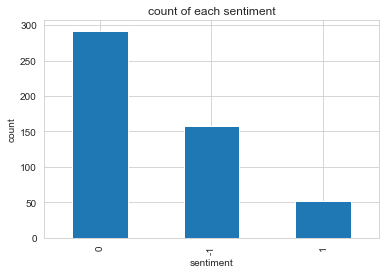

In [228]:
# Can change -1 to negative....
character_to_type['sentiment'].value_counts().plot(kind='bar', xlabel= 'sentiment', ylabel = 'count', title = 'count of each sentiment')

### 6) IMDb Actors dataset

In [59]:
# IMDb actors dataset
imdb_actors_df = pd.read_csv('data/imdb_name_basics.tsv', sep='	')

In [60]:
imdb_actors_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0050419,tt0053137"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0071877,tt0117057,tt0037382,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0054452,tt0056404,tt0057345"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0078723,tt0077975,tt0080455,tt0072562"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0050976,tt0060827,tt0050986"


In [61]:
# Create a column for each of the titles an actor is known for

def get_title_by_index(index):
    def f(array):
        list_ids = array.split(",")
        corresponding_id = ""
        if index < len(list_ids):
            corresponding_id = list_ids[index]
        return corresponding_id

    return f

imdb_actors_df['knownForTitles1'] = imdb_actors_df['knownForTitles'].apply(get_title_by_index(0))
imdb_actors_df['knownForTitles2'] = imdb_actors_df['knownForTitles'].apply(get_title_by_index(1))
imdb_actors_df['knownForTitles3'] = imdb_actors_df['knownForTitles'].apply(get_title_by_index(2))
imdb_actors_df['knownForTitles4'] = imdb_actors_df['knownForTitles'].apply(get_title_by_index(3))

In [62]:
imdb_actors_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,knownForTitles1,knownForTitles2,knownForTitles3,knownForTitles4
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0050419,tt0053137",tt0031983,tt0072308,tt0050419,tt0053137
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0071877,tt0117057,tt0037382,tt0038355",tt0071877,tt0117057,tt0037382,tt0038355
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0054452,tt0056404,tt0057345",tt0049189,tt0054452,tt0056404,tt0057345
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0078723,tt0077975,tt0080455,tt0072562",tt0078723,tt0077975,tt0080455,tt0072562
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0050976,tt0060827,tt0050986",tt0083922,tt0050976,tt0060827,tt0050986


In [63]:
# IMDb movies' metadata dataset
imdb_names_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama


In [64]:
imdb_names_reduced_df = imdb_names_df[["tconst", "primaryTitle"]]

In [65]:
imdb_names_reduced_df.head()

,tconst,primaryTitle
8,tt0000009,Miss Jerry
498,tt0000502,Bohemios
570,tt0000574,The Story of the Kelly Gang
587,tt0000591,The Prodigal Son
610,tt0000615,Robbery Under Arms


In [70]:
def assign_known_title(index, actors_df, names_df):
    actors_df = actors_df.merge(names_df, left_on="knownForTitles{}".format(index), right_on = 'tconst', how='inner')
    actors_df["knownForTitles{}".format(index)] = actors_df['primaryTitle']
    actors_df = actors_df.drop('tconst', axis=1)
    actors_df = actors_df.drop('primaryTitle', axis=1)
    return actors_df

In [71]:
imdb_actors_df = assign_known_title(1, imdb_actors_df, imdb_names_reduced_df)
imdb_actors_df = assign_known_title(2, imdb_actors_df, imdb_names_reduced_df)
imdb_actors_df = assign_known_title(3, imdb_actors_df, imdb_names_reduced_df)
imdb_actors_df = assign_known_title(4, imdb_actors_df, imdb_names_reduced_df)

In [72]:
imdb_actors_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,knownForTitles1,knownForTitles2,knownForTitles3,knownForTitles4
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0050419,tt0053137",The Story of Vernon and Irene Castle,The Towering Inferno,Funny Face,On the Beach
1,nm0461772,Frederic Knudtson,1906,1964,"editor,editorial_department","tt0053946,tt0055031,tt0057193,tt0053137",Inherit the Wind,Judgment at Nuremberg,It's a Mad Mad Mad Mad World,On the Beach
2,nm0254666,Walter Elliott,1903,1984,"sound_department,music_department","tt0057193,tt0053946,tt0055031,tt0053137",It's a Mad Mad Mad Mad World,Inherit the Wind,Judgment at Nuremberg,On the Beach
3,nm1298827,Marie Cowan,\N,\N,"soundtrack,composer","tt0455824,tt0220134,tt0105824,tt0053137",Australia,Up Jumped a Swagman,Wind,On the Beach
4,nm0542596,Nellie Manley,1894,1976,make_up_department,"tt0052357,tt0054698,tt0050419,tt0051201",Vertigo,Breakfast at Tiffany's,Funny Face,Witness for the Prosecution


In [73]:
result = imdb_actors_df[imdb_actors_df['primaryName'] == "Leonardo DiCaprio"]

In [75]:
result.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,knownForTitles1,knownForTitles2,knownForTitles3,knownForTitles4
13266,nm0000138,Leonardo DiCaprio,1974,\N,"actor,producer,soundtrack","tt0993846,tt0120338,tt0407887,tt1375666",The Wolf of Wall Street,Titanic,The Departed,Inception


### 6) Plot analysis